# Section 1.0 Preface & Disclaimer

From the get-go, we realized the importance of seasonality factoring into the analysis of this dataset, but in a more genreral/holistic view, it was due to the data being a time-series spanning two years, with entries (rows) between every hour.

Due to the recent release of NeuralProphet by joint collaboration from Stanford & Facebook (now Meta), solely targeted towards Time-Series Analysis, we have decided to leverage this model format to build our predictive analysis off of.

In [1]:
!pip install neuralprophet

In [2]:
from neuralprophet import NeuralProphet
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed 

import pandas as pd
import numpy as np

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

# Section 1.0 Data Display & Description

Using the below predictors/descriptions we output the first `20` entries (rows) as well as basic descriptive statistics of the dataset.

The data is provided to you in NYU Brightspace. It contains 17414 records in total,
ranging from 2015-01-04 to 2017-01-03. In each record, we have the following columns:

* "timestamp" - timestamp field for grouping the data
* "cnt" - the count of new bike shares
* "t1" - real temperature in Celsius
* "t2" - "feels like" temperature in Celsius
* "hum" - humidity in percentage
* "windspeed" - wind speed in km/h
* "weathercode" - category of the weather (1-clear; 2-scattered clouds; 3-broken clouds; 4-
* cloudy; 7-light rain; 10-rain with thunderstorm; 26-snowfall; 94-freezing fog)
* "isholiday" – binary variable - 1 holiday / 0 non holiday
* "isweekend" - binary variable - 1 if the day is weekend / 0 non weekend
* "season" – category of the season (0-spring ; 1-summer; 2-fall; 3-winter)

In [3]:
df = pd.read_csv('bike_sharing_dataset.csv')
set_random_seed(1234567)

df.head(20)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [4]:
df.describe(include='all')

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
unique,17414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,NaN,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,NaN,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,NaN,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,NaN,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,NaN,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to d

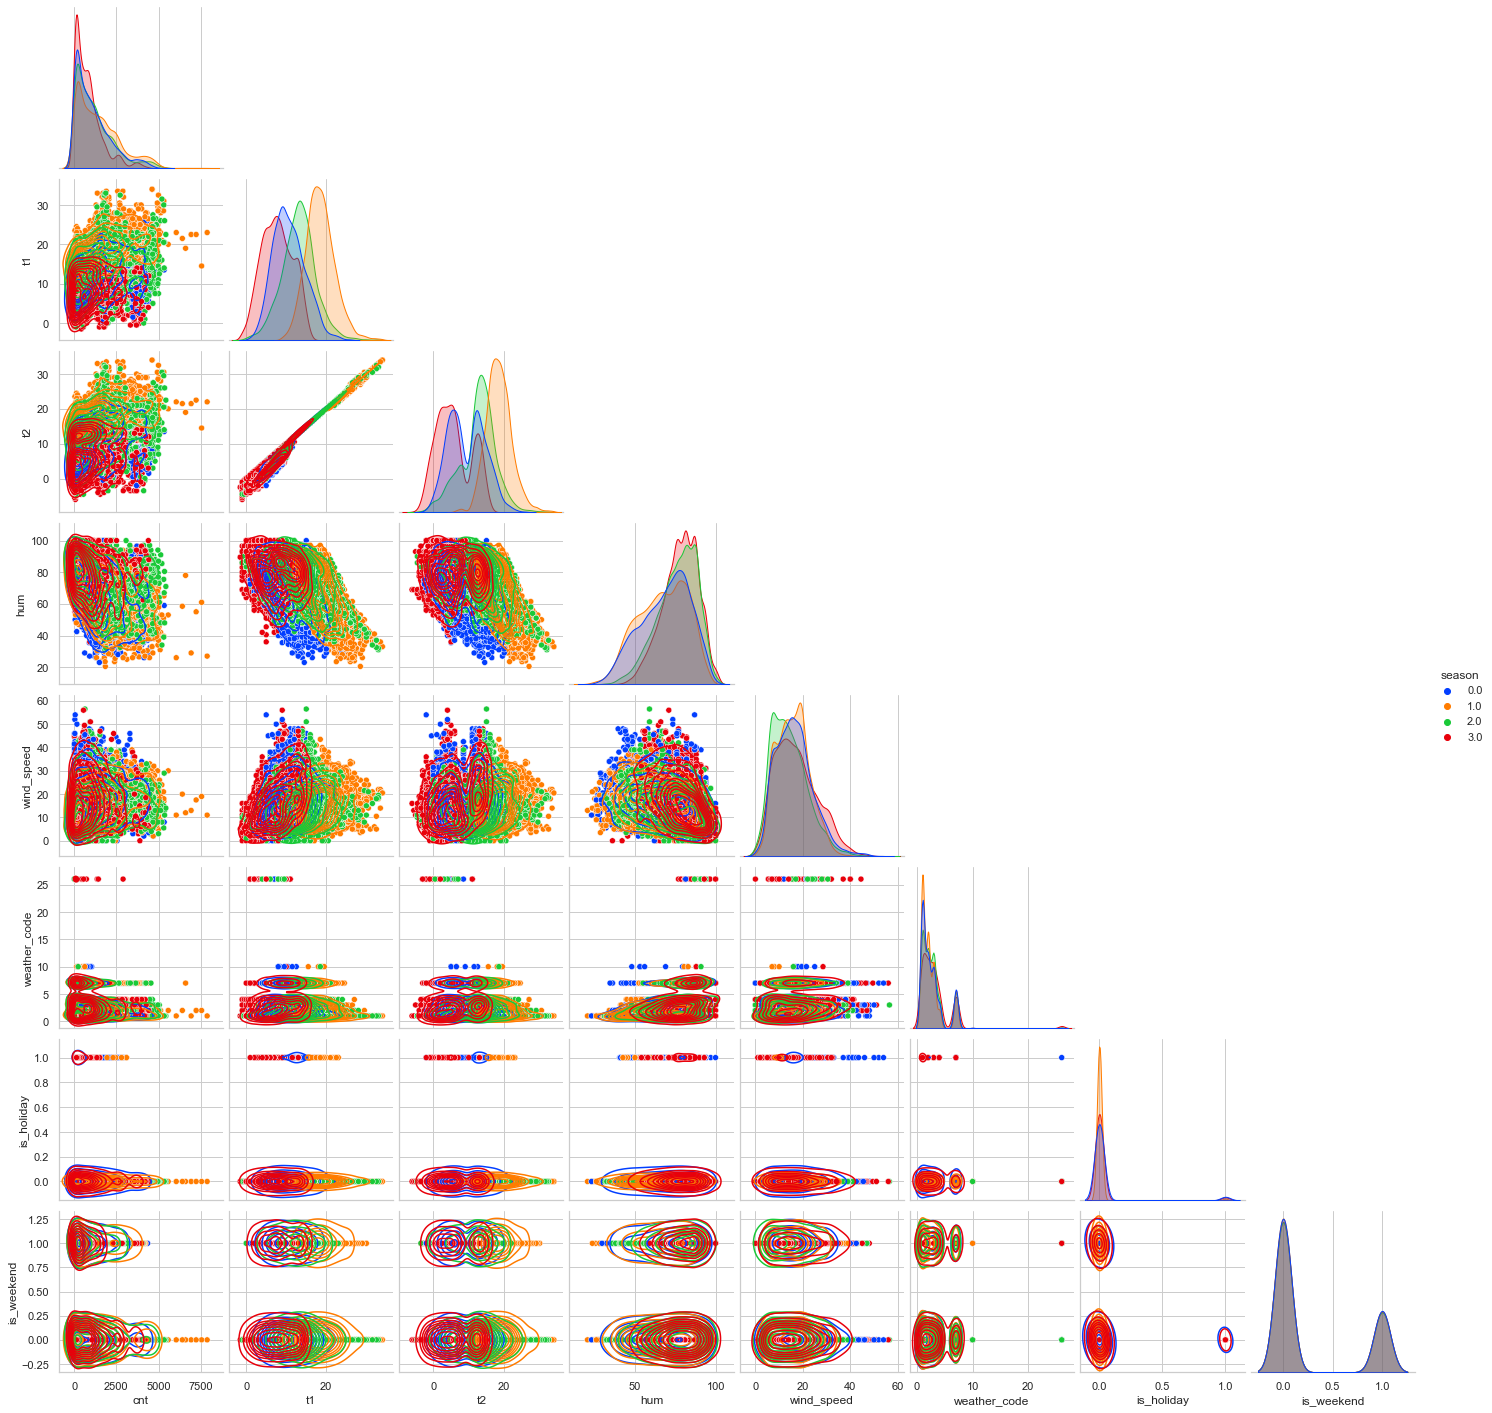

In [6]:
pairplt = sns.pairplot(data=df, hue='season', corner=True, palette='bright')
pairplt.map_lower(sns.kdeplot, levels=10, color=".2")

# Section 2.0 `NeuralProphet` Model Initialization & Fitting

In [7]:
df_test = df.rename(columns={'timestamp': 'ds', 'cnt': 'y'})[['ds', 'y']]

In [8]:
model = NeuralProphet()
metrics = model.fit(df_test, freq='H')

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 89


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.37E-02, min: 7.11E-01


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.32E-02, min: 8.12E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.49E-02
Epoch[89/89]: 100%|██████████| 89/89 [00:25<00:00,  3.53it/s, SmoothL1Loss=0.0163, MAE=430, RMSE=632, RegLoss=0]     


In [9]:
def plot_forecast(model, data, periods, historic_pred=True, highlight_steps_ahead=None):
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast)
    else:    
        model.plot(forecast)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.9/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is deprecated a

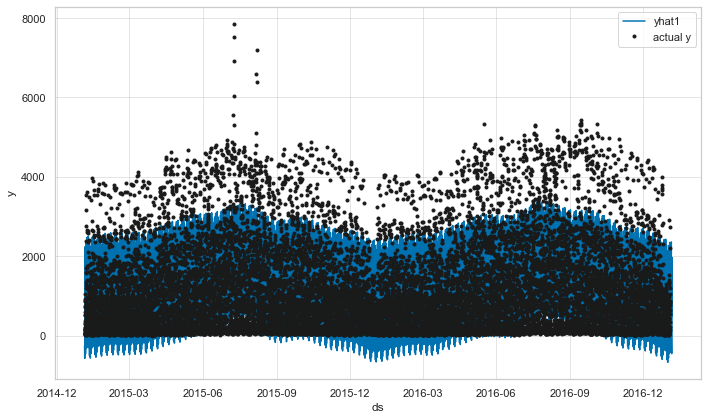

In [10]:
plot_forecast(model, df_test, periods=60)